# learning curve 出す

In [9]:
import numpy as np
import gensim
import requests
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [12]:
#dataのインポート+シャッフル
data = pd.read_csv("./1_preprocessed_data.csv",index_col = 0).sample(frac=1, random_state=1).reset_index(drop=True)


In [13]:
#カラム配列定義
#特徴量カラム
feature_columns =  ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup",
                "is_include_word","bert_sim","lexvec_diff","wiki2vec_diff","bert_diff"]


#通常の特徴量ラベル
X_normal_columns = ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup","is_include_word","bert_sim"]

#ベクトル系特徴量ラベル
pca_di={"lexvec_diff":30,"wiki2vec_diff":30,"bert_diff":3}

#被験者実験データ
ans_columns = [ 'ans_ueda',
       'ans_daisuke', 'ans_kazuma', 'ans_sugi','ans_yamasaki','ans_hosomi']

In [14]:

# 欠損値は最頻値補完を行う
def fill_na_mean(data):
    data.loc[:,"sim_by_mcg"] = data.loc[:,"sim_by_mcg"].fillna(data.loc[:,"sim_by_mcg"].mode()[0])
    data.loc[:,"is_a_by_mcg"] = data.loc[:,"is_a_by_mcg"].fillna(data.loc[:,"is_a_by_mcg"].mode()[0])
    data.loc[:,"wiki2vec_sim"] = data.loc[:,"wiki2vec_sim"].fillna(data.loc[:,"wiki2vec_sim"].mode()[0])
    data.loc[:,"wiki2vec_diff"] = data.loc[:,"wiki2vec_diff"].fillna(data.loc[:,"wiki2vec_diff"].mode()[0])
    return data
data = fill_na_mean(data)
#クラスラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
def label_encorder(data):
    le = LabelEncoder()
    encoded = le.fit_transform(data['relation'].values)
    for ans_c in ans_columns:
        temp_label = le.transform(data[ans_c].values)
        data[ans_c] = temp_label
    data.loc[:,'relation_label'] = encoded
    print(str(data["relation"].unique())+","+str(le.transform(data["relation"].unique())))
    return data
data = label_encorder(data)

['s1' 'h2' 'h1' 's2' 'k'],[3 1 0 4 2]


In [15]:
#特徴量の選別 wn_sim_jcnは値がバグっているので使わない(infinityが入っている)
X_data = data.loc[:,feature_columns]
# yの定義
y = data.loc[:,"relation_label"].values.astype("int32")

In [16]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#通常の特徴量ラベル
X_normal_columns = ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup","is_include_word","bert_sim"]

#diffラベルのpca_ssモデル trainとtest arrを返す
def ss_pca(train,pca_n):
    scaler = StandardScaler()
    train=scaler.fit_transform(train)
    pca = PCA(n_components = pca_n)
    train = pca.fit_transform(train)
    return train
#str_arrをarrに変換
def convert_to_arr(vec_str):
    vec_arr = None
    for s in vec_str:
        if vec_arr is None:
            vec_arr =np.array(s[1:-1].split(", ")).astype("float32")
        else:
            vec_arr = np.block([[vec_arr],[np.array(s[1:-1].split(", ")).astype("float32")]])
    return vec_arr

In [18]:


#pca成分の生成
from sklearn.model_selection import StratifiedKFold,LeaveOneOut,KFold
from copy import deepcopy
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
def learning(X_data,y):
    
    skf = StratifiedKFold(n_splits=5,random_state = 0)
    cm = None #混合配列
    v_acc = list()
    for train_idx, test_idx in skf.split(X_data,y):
        #print("new epoc")

        #diff系以外をarrayに入れる 
        X = X_data.loc[:,X_normal_columns].values.astype("float64").astype("float64")


        # ベクトル系カラムをpcaする
        for column, n in pca_di.items():
            vec_arr = convert_to_arr(X_data.loc[:,column])
            pca_arr = ss_pca(vec_arr,n)
            X = np.concatenate([X, pca_arr], 1)


        #分割
        X_train = X[train_idx,:]
        X_test = X[test_idx,:]
        y_train = y[train_idx]
        y_test = y[test_idx]
        #print(X_train.shape)

        #LDA
        """
        lda = PCA()
        X_train = lda.fit_transform(X_train, y_train)
        X_test = lda.transform(X_test)
        """
        #XGBOOST
        #model = xgb.XGBClassifier(n_estimators=1500,max_depth=25,learning_rate=0.01)
        model = xgb.XGBClassifier(n_estimators=100,max_depth=10,learning_rate=0.01)
        model.fit(X_train,y_train)
        
        #トレーニングスコアの算出
        #y_pred = model.predict(X_train)
        #t_acc.append(accuracy_score(y_pred, y_train))
        
        
        #検証スコアの算出
        y_pred = model.predict(X_test)
        #print(accuracy_score(y_test, y_pred))
        v_acc.append(accuracy_score(y_test, y_pred))
        
        cm_temp = confusion_matrix(y_pred, y_test)
        if cm is None:
            cm = cm_temp
            continue
        cm = cm + cm_temp
        
    #result
    import seaborn as sns
    #print(v_acc)
    return v_acc

In [23]:


v_acc_li = list()
for i in range(200,420,1):
    print(i)
    v_acc = learning(X_data[0:i],y[0:i])
    v_acc_li.append(v_acc)
    print(np.mean(v_acc))

/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
new epoc
[0.475, 0.575, 0.5, 0.475, 0.575]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5121951219512195, 0.575, 0.5, 0.475, 0.45]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5609756097560976, 0.5365853658536586, 0.475, 0.35, 0.475]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5121951219512195, 0.5365853658536586, 0.5365853658536586, 0.475, 0.4]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.4878048780487805, 0.5365853658536586, 0.4146341463414634, 0.3902439024390244, 0.45]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5365853658536586, 0.5365853658536586, 0.43902439024390244, 0.5121951219512195, 0.5121951219512195]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5238095238095238, 0.6097560975609756, 0.3902439024390244, 0.6097560975609756, 0.43902439024390244]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5, 0.5, 0.4634146341463415, 0.5853658536585366, 0.5609756097560976]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.47619047619047616, 0.5476190476190477, 0.42857142857142855, 0.5609756097560976, 0.4634146341463415]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.4523809523809524, 0.5238095238095238, 0.5238095238095238, 0.40476190476190477, 0.4878048780487805]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.40476190476190477, 0.4523809523809524, 0.3333333333333333, 0.4523809523809524, 0.4523809523809524]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.4186046511627907, 0.5476190476190477, 0.47619047619047616, 0.40476190476190477, 0.4523809523809524]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.4883720930232558, 0.5348837209302325, 0.47619047619047616, 0.47619047619047616, 0.5476190476190477]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.4186046511627907, 0.4883720930232558, 0.5813953488372093, 0.47619047619047616, 0.5238095238095238]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.4418604651162791, 0.5116279069767442, 0.37209302325581395, 0.4186046511627907, 0.35714285714285715]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5116279069767442, 0.4418604651162791, 0.4883720930232558, 0.37209302325581395, 0.5348837209302325]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6363636363636364, 0.5348837209302325, 0.5581395348837209, 0.4186046511627907, 0.5348837209302325]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5227272727272727, 0.4772727272727273, 0.4186046511627907, 0.4186046511627907, 0.4883720930232558]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5, 0.5, 0.4772727272727273, 0.32558139534883723, 0.5813953488372093]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5681818181818182, 0.5227272727272727, 0.5227272727272727, 0.45454545454545453, 0.5116279069767442]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5909090909090909, 0.4318181818181818, 0.6136363636363636, 0.4090909090909091, 0.5454545454545454]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5333333333333333, 0.3409090909090909, 0.5, 0.5454545454545454, 0.5681818181818182]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.4888888888888889, 0.5111111111111111, 0.4772727272727273, 0.4090909090909091, 0.5909090909090909]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.4444444444444444, 0.5111111111111111, 0.4666666666666667, 0.5227272727272727, 0.5454545454545454]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6222222222222222, 0.4222222222222222, 0.4666666666666667, 0.4222222222222222, 0.4772727272727273]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6, 0.37777777777777777, 0.5111111111111111, 0.4222222222222222, 0.4444444444444444]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.4782608695652174, 0.4, 0.5333333333333333, 0.4, 0.4888888888888889]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5652173913043478, 0.5217391304347826, 0.5111111111111111, 0.5777777777777777, 0.5111111111111111]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5434782608695652, 0.5434782608695652, 0.5652173913043478, 0.5777777777777777, 0.5555555555555556]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5652173913043478, 0.5652173913043478, 0.5869565217391305, 0.4782608695652174, 0.5333333333333333]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6304347826086957, 0.5434782608695652, 0.5434782608695652, 0.5, 0.43478260869565216]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6382978723404256, 0.5434782608695652, 0.5217391304347826, 0.5, 0.45652173913043476]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6382978723404256, 0.5106382978723404, 0.5434782608695652, 0.5217391304347826, 0.41304347826086957]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5957446808510638, 0.5531914893617021, 0.5319148936170213, 0.5217391304347826, 0.45652173913043476]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.574468085106383, 0.5531914893617021, 0.44680851063829785, 0.574468085106383, 0.41304347826086957]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5957446808510638, 0.5531914893617021, 0.5957446808510638, 0.574468085106383, 0.425531914893617]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.625, 0.6595744680851063, 0.5957446808510638, 0.5957446808510638, 0.5106382978723404]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6458333333333334, 0.625, 0.48936170212765956, 0.5319148936170213, 0.5106382978723404]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5208333333333334, 0.625, 0.5416666666666666, 0.5319148936170213, 0.44680851063829785]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.7083333333333334, 0.6458333333333334, 0.5625, 0.5, 0.5319148936170213]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5833333333333334, 0.5833333333333334, 0.625, 0.5833333333333334, 0.4583333333333333]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.673469387755102, 0.625, 0.5416666666666666, 0.5, 0.5833333333333334]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6938775510204082, 0.5510204081632653, 0.5416666666666666, 0.4791666666666667, 0.5416666666666666]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6122448979591837, 0.6326530612244898, 0.40816326530612246, 0.5, 0.5625]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6122448979591837, 0.5714285714285714, 0.4489795918367347, 0.4897959183673469, 0.5416666666666666]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5918367346938775, 0.6122448979591837, 0.5102040816326531, 0.3877551020408163, 0.5306122448979592]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.58, 0.5714285714285714, 0.5510204081632653, 0.4897959183673469, 0.4897959183673469]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.54, 0.56, 0.5918367346938775, 0.3673469387755102, 0.5918367346938775]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.64, 0.58, 0.54, 0.42857142857142855, 0.6530612244897959]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.48, 0.62, 0.52, 0.44, 0.5510204081632653]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.56, 0.54, 0.6, 0.44, 0.48]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5490196078431373, 0.58, 0.58, 0.38, 0.56]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.49019607843137253, 0.6078431372549019, 0.52, 0.44, 0.48]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6274509803921569, 0.6274509803921569, 0.47058823529411764, 0.46, 0.44]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5882352941176471, 0.5882352941176471, 0.49019607843137253, 0.47058823529411764, 0.42]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5686274509803921, 0.5882352941176471, 0.5294117647058824, 0.5294117647058824, 0.47058823529411764]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6153846153846154, 0.5686274509803921, 0.47058823529411764, 0.5686274509803921, 0.49019607843137253]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6346153846153846, 0.5961538461538461, 0.47058823529411764, 0.5098039215686274, 0.5098039215686274]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6923076923076923, 0.5961538461538461, 0.5, 0.49019607843137253, 0.5294117647058824]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6730769230769231, 0.5384615384615384, 0.5, 0.5192307692307693, 0.5490196078431373]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5384615384615384, 0.6538461538461539, 0.6153846153846154, 0.5961538461538461, 0.5192307692307693]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5283018867924528, 0.6346153846153846, 0.5769230769230769, 0.5576923076923077, 0.5]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6226415094339622, 0.5283018867924528, 0.5384615384615384, 0.6730769230769231, 0.4807692307692308]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5849056603773585, 0.4339622641509434, 0.5283018867924528, 0.7115384615384616, 0.4423076923076923]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6226415094339622, 0.4528301886792453, 0.5094339622641509, 0.6792452830188679, 0.46153846153846156]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6037735849056604, 0.5849056603773585, 0.5283018867924528, 0.6415094339622641, 0.41509433962264153]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5925925925925926, 0.5660377358490566, 0.4716981132075472, 0.5660377358490566, 0.5471698113207547]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5740740740740741, 0.5, 0.37735849056603776, 0.5660377358490566, 0.4716981132075472]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5925925925925926, 0.5185185185185185, 0.46296296296296297, 0.6415094339622641, 0.4528301886792453]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5925925925925926, 0.5370370370370371, 0.4444444444444444, 0.6111111111111112, 0.5094339622641509]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5925925925925926, 0.5, 0.46296296296296297, 0.5740740740740741, 0.5370370370370371]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6, 0.5185185185185185, 0.5370370370370371, 0.6481481481481481, 0.5555555555555556]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5454545454545454, 0.509090909090909, 0.5370370370370371, 0.5925925925925926, 0.5555555555555556]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.509090909090909, 0.5454545454545454, 0.5272727272727272, 0.5555555555555556, 0.5740740740740741]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5636363636363636, 0.5272727272727272, 0.4909090909090909, 0.5636363636363636, 0.6481481481481481]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5454545454545454, 0.5454545454545454, 0.5636363636363636, 0.5636363636363636, 0.6181818181818182]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5357142857142857, 0.43636363636363634, 0.5636363636363636, 0.5272727272727272, 0.6]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5357142857142857, 0.5892857142857143, 0.5818181818181818, 0.5636363636363636, 0.6363636363636364]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5714285714285714, 0.5178571428571429, 0.5535714285714286, 0.5636363636363636, 0.5272727272727272]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5892857142857143, 0.48214285714285715, 0.5535714285714286, 0.5, 0.6]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6071428571428571, 0.5357142857142857, 0.5535714285714286, 0.5178571428571429, 0.5535714285714286]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6140350877192983, 0.4642857142857143, 0.6607142857142857, 0.5714285714285714, 0.6071428571428571]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5789473684210527, 0.49122807017543857, 0.625, 0.6071428571428571, 0.42857142857142855]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6491228070175439, 0.49122807017543857, 0.5614035087719298, 0.5714285714285714, 0.4642857142857143]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.543859649122807, 0.5789473684210527, 0.5614035087719298, 0.543859649122807, 0.5357142857142857]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.7017543859649122, 0.5263157894736842, 0.49122807017543857, 0.543859649122807, 0.5087719298245614]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6551724137931034, 0.543859649122807, 0.47368421052631576, 0.5614035087719298, 0.5263157894736842]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6206896551724138, 0.5, 0.5263157894736842, 0.5087719298245614, 0.5964912280701754]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5517241379310345, 0.5517241379310345, 0.4482758620689655, 0.47368421052631576, 0.5263157894736842]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5862068965517241, 0.5517241379310345, 0.5172413793103449, 0.5517241379310345, 0.543859649122807]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6896551724137931, 0.603448275862069, 0.5689655172413793, 0.5689655172413793, 0.5172413793103449]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.711864406779661, 0.4827586206896552, 0.5689655172413793, 0.603448275862069, 0.5689655172413793]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6610169491525424, 0.559322033898305, 0.5344827586206896, 0.6379310344827587, 0.5172413793103449]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6779661016949152, 0.4745762711864407, 0.5254237288135594, 0.5862068965517241, 0.5689655172413793]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6610169491525424, 0.5423728813559322, 0.576271186440678, 0.6101694915254238, 0.5172413793103449]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6440677966101694, 0.5423728813559322, 0.6271186440677966, 0.5932203389830508, 0.5423728813559322]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.65, 0.5084745762711864, 0.6101694915254238, 0.5084745762711864, 0.4915254237288136]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6833333333333333, 0.55, 0.4915254237288136, 0.559322033898305, 0.5932203389830508]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6333333333333333, 0.5, 0.5333333333333333, 0.576271186440678, 0.576271186440678]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.65, 0.5166666666666667, 0.6, 0.5333333333333333, 0.4745762711864407]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.7333333333333333, 0.48333333333333334, 0.48333333333333334, 0.5666666666666667, 0.6166666666666667]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.7213114754098361, 0.45, 0.55, 0.65, 0.5666666666666667]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.639344262295082, 0.45901639344262296, 0.5333333333333333, 0.55, 0.55]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6065573770491803, 0.4426229508196721, 0.5245901639344263, 0.5166666666666667, 0.5333333333333333]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.7049180327868853, 0.4426229508196721, 0.5573770491803278, 0.5409836065573771, 0.5333333333333333]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6557377049180327, 0.4262295081967213, 0.5245901639344263, 0.5573770491803278, 0.5737704918032787]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5967741935483871, 0.4262295081967213, 0.5245901639344263, 0.5573770491803278, 0.5573770491803278]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6774193548387096, 0.532258064516129, 0.5901639344262295, 0.5081967213114754, 0.5901639344262295]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6935483870967742, 0.5645161290322581, 0.532258064516129, 0.5081967213114754, 0.5573770491803278]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6451612903225806, 0.46774193548387094, 0.532258064516129, 0.46774193548387094, 0.4426229508196721]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.7096774193548387, 0.45161290322580644, 0.6129032258064516, 0.43548387096774194, 0.532258064516129]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6666666666666666, 0.5161290322580645, 0.5483870967741935, 0.45161290322580644, 0.532258064516129]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6349206349206349, 0.5873015873015873, 0.6129032258064516, 0.5645161290322581, 0.532258064516129]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6666666666666666, 0.5079365079365079, 0.5873015873015873, 0.5161290322580645, 0.5]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6666666666666666, 0.6190476190476191, 0.5238095238095238, 0.5396825396825397, 0.5483870967741935]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5555555555555556, 0.5714285714285714, 0.47619047619047616, 0.5238095238095238, 0.5396825396825397]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.625, 0.49206349206349204, 0.5238095238095238, 0.5079365079365079, 0.5238095238095238]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.640625, 0.515625, 0.4603174603174603, 0.5079365079365079, 0.5396825396825397]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5625, 0.5, 0.515625, 0.5079365079365079, 0.5396825396825397]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.671875, 0.578125, 0.578125, 0.515625, 0.5396825396825397]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.65625, 0.53125, 0.546875, 0.546875, 0.515625]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6153846153846154, 0.40625, 0.484375, 0.59375, 0.453125]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6153846153846154, 0.4, 0.53125, 0.578125, 0.46875]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6923076923076923, 0.5230769230769231, 0.6153846153846154, 0.53125, 0.546875]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6615384615384615, 0.5384615384615384, 0.5846153846153846, 0.5230769230769231, 0.53125]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.7076923076923077, 0.5384615384615384, 0.46153846153846156, 0.5538461538461539, 0.5692307692307692]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6666666666666666, 0.5538461538461539, 0.6, 0.6307692307692307, 0.676923076923077]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6666666666666666, 0.45454545454545453, 0.5538461538461539, 0.5230769230769231, 0.6]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6363636363636364, 0.5303030303030303, 0.5757575757575758, 0.47692307692307695, 0.5846153846153846]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6212121212121212, 0.5454545454545454, 0.5303030303030303, 0.5303030303030303, 0.5692307692307692]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6212121212121212, 0.42424242424242425, 0.5454545454545454, 0.5606060606060606, 0.5606060606060606]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6119402985074627, 0.5303030303030303, 0.5606060606060606, 0.6363636363636364, 0.5303030303030303]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5970149253731343, 0.5223880597014925, 0.5151515151515151, 0.5909090909090909, 0.5151515151515151]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6119402985074627, 0.47761194029850745, 0.5223880597014925, 0.6212121212121212, 0.4696969696969697]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5671641791044776, 0.4626865671641791, 0.4925373134328358, 0.5970149253731343, 0.48484848484848486]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6268656716417911, 0.47761194029850745, 0.5223880597014925, 0.5522388059701493, 0.47761194029850745]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6029411764705882, 0.373134328358209, 0.43283582089552236, 0.5522388059701493, 0.4626865671641791]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6617647058823529, 0.4852941176470588, 0.47761194029850745, 0.4925373134328358, 0.43283582089552236]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5588235294117647, 0.5441176470588235, 0.5, 0.5373134328358209, 0.47761194029850745]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6029411764705882, 0.5, 0.47058823529411764, 0.5147058823529411, 0.4626865671641791]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6176470588235294, 0.5, 0.5, 0.5441176470588235, 0.4852941176470588]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5652173913043478, 0.5294117647058824, 0.5294117647058824, 0.5294117647058824, 0.4852941176470588]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5362318840579711, 0.4927536231884058, 0.5588235294117647, 0.5882352941176471, 0.4852941176470588]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6231884057971014, 0.5507246376811594, 0.5507246376811594, 0.5294117647058824, 0.47058823529411764]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5797101449275363, 0.5072463768115942, 0.5797101449275363, 0.5507246376811594, 0.45588235294117646]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5942028985507246, 0.5362318840579711, 0.4927536231884058, 0.5942028985507246, 0.4927536231884058]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6, 0.5507246376811594, 0.4927536231884058, 0.5652173913043478, 0.4782608695652174]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5571428571428572, 0.4857142857142857, 0.5507246376811594, 0.5217391304347826, 0.4927536231884058]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5571428571428572, 0.4857142857142857, 0.5714285714285714, 0.5507246376811594, 0.43478260869565216]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6285714285714286, 0.5428571428571428, 0.5714285714285714, 0.5285714285714286, 0.4492753623188406]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6571428571428571, 0.5, 0.45714285714285713, 0.5285714285714286, 0.4857142857142857]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5774647887323944, 0.4714285714285714, 0.4857142857142857, 0.5571428571428572, 0.44285714285714284]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5492957746478874, 0.4225352112676056, 0.5428571428571428, 0.5857142857142857, 0.5]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6338028169014085, 0.4647887323943662, 0.5633802816901409, 0.5, 0.4857142857142857]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5774647887323944, 0.4507042253521127, 0.5774647887323944, 0.5352112676056338, 0.4714285714285714]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5915492957746479, 0.5070422535211268, 0.5492957746478874, 0.5352112676056338, 0.43661971830985913]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6666666666666666, 0.4507042253521127, 0.5774647887323944, 0.5774647887323944, 0.5070422535211268]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5833333333333334, 0.4444444444444444, 0.5352112676056338, 0.5211267605633803, 0.4788732394366197]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6805555555555556, 0.5, 0.5833333333333334, 0.5352112676056338, 0.49295774647887325]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5972222222222222, 0.4305555555555556, 0.5277777777777778, 0.5277777777777778, 0.5070422535211268]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6666666666666666, 0.5, 0.5972222222222222, 0.5277777777777778, 0.5138888888888888]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6027397260273972, 0.4166666666666667, 0.5833333333333334, 0.5694444444444444, 0.4861111111111111]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6027397260273972, 0.4520547945205479, 0.5277777777777778, 0.5833333333333334, 0.4722222222222222]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6301369863013698, 0.4657534246575342, 0.547945205479452, 0.4861111111111111, 0.4444444444444444]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6438356164383562, 0.4246575342465753, 0.5342465753424658, 0.5616438356164384, 0.5694444444444444]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6164383561643836, 0.3835616438356164, 0.589041095890411, 0.5616438356164384, 0.5753424657534246]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.581081081081081, 0.4520547945205479, 0.6438356164383562, 0.4931506849315068, 0.547945205479452]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6756756756756757, 0.5, 0.6301369863013698, 0.5342465753424658, 0.6027397260273972]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6621621621621622, 0.527027027027027, 0.5675675675675675, 0.6301369863013698, 0.547945205479452]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6216216216216216, 0.4864864864864865, 0.5945945945945946, 0.5945945945945946, 0.547945205479452]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5945945945945946, 0.4594594594594595, 0.6486486486486487, 0.5540540540540541, 0.5135135135135135]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6533333333333333, 0.47297297297297297, 0.5405405405405406, 0.5405405405405406, 0.581081081081081]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6266666666666667, 0.52, 0.5675675675675675, 0.5405405405405406, 0.5945945945945946]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5466666666666666, 0.5066666666666667, 0.6133333333333333, 0.581081081081081, 0.6081081081081081]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.56, 0.5733333333333334, 0.6133333333333333, 0.6, 0.5540540540540541]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5866666666666667, 0.56, 0.5333333333333333, 0.5733333333333334, 0.56]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5657894736842105, 0.49333333333333335, 0.52, 0.6, 0.52]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5921052631578947, 0.4605263157894737, 0.56, 0.64, 0.5866666666666667]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6842105263157895, 0.5263157894736842, 0.5921052631578947, 0.6266666666666667, 0.5466666666666666]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6842105263157895, 0.5526315789473685, 0.6052631578947368, 0.6578947368421053, 0.5466666666666666]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.631578947368421, 0.5394736842105263, 0.6447368421052632, 0.5921052631578947, 0.5394736842105263]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6233766233766234, 0.5263157894736842, 0.6447368421052632, 0.618421052631579, 0.618421052631579]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5844155844155844, 0.4675324675324675, 0.5921052631578947, 0.5394736842105263, 0.5789473684210527]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5584415584415584, 0.4935064935064935, 0.5844155844155844, 0.5657894736842105, 0.5394736842105263]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6363636363636364, 0.42857142857142855, 0.5974025974025974, 0.6103896103896104, 0.6447368421052632]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6753246753246753, 0.4675324675324675, 0.5584415584415584, 0.5714285714285714, 0.6233766233766234]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6153846153846154, 0.5064935064935064, 0.6753246753246753, 0.6103896103896104, 0.5454545454545454]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6666666666666666, 0.46153846153846156, 0.6103896103896104, 0.6233766233766234, 0.5584415584415584]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6282051282051282, 0.4230769230769231, 0.5641025641025641, 0.5714285714285714, 0.5194805194805194]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5897435897435898, 0.46153846153846156, 0.6538461538461539, 0.5769230769230769, 0.5454545454545454]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6538461538461539, 0.46153846153846156, 0.5769230769230769, 0.5769230769230769, 0.5769230769230769]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6962025316455697, 0.5, 0.6025641025641025, 0.5, 0.47435897435897434]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6455696202531646, 0.45569620253164556, 0.6410256410256411, 0.48717948717948717, 0.6025641025641025]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6582278481012658, 0.4936708860759494, 0.5949367088607594, 0.5512820512820513, 0.5256410256410257]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.569620253164557, 0.5189873417721519, 0.5316455696202531, 0.620253164556962, 0.5256410256410257]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5569620253164557, 0.5189873417721519, 0.5443037974683544, 0.6329113924050633, 0.5189873417721519]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.575, 0.4810126582278481, 0.569620253164557, 0.5569620253164557, 0.620253164556962]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6, 0.475, 0.6075949367088608, 0.5316455696202531, 0.5822784810126582]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6375, 0.45, 0.6625, 0.5443037974683544, 0.5822784810126582]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5875, 0.425, 0.6, 0.4875, 0.5316455696202531]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.625, 0.475, 0.5875, 0.5, 0.5125]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.7037037037037037, 0.4625, 0.6, 0.525, 0.55]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6419753086419753, 0.4074074074074074, 0.5625, 0.6, 0.5875]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6172839506172839, 0.4691358024691358, 0.5802469135802469, 0.575, 0.625]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5925925925925926, 0.49382716049382713, 0.5925925925925926, 0.5555555555555556, 0.6375]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5925925925925926, 0.5185185185185185, 0.5679012345679012, 0.5802469135802469, 0.5555555555555556]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6341463414634146, 0.3950617283950617, 0.5679012345679012, 0.5679012345679012, 0.5555555555555556]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6097560975609756, 0.524390243902439, 0.5185185185185185, 0.5802469135802469, 0.5679012345679012]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5975609756097561, 0.45121951219512196, 0.573170731707317, 0.6172839506172839, 0.6172839506172839]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6707317073170732, 0.5, 0.6219512195121951, 0.5609756097560976, 0.6049382716049383]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5853658536585366, 0.5121951219512195, 0.6463414634146342, 0.5121951219512195, 0.5975609756097561]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6265060240963856, 0.524390243902439, 0.6097560975609756, 0.5487804878048781, 0.6219512195121951]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6385542168674698, 0.4819277108433735, 0.6097560975609756, 0.5365853658536586, 0.6585365853658537]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6506024096385542, 0.4819277108433735, 0.5783132530120482, 0.524390243902439, 0.6097560975609756]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5783132530120482, 0.5060240963855421, 0.6024096385542169, 0.5421686746987951, 0.5609756097560976]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6265060240963856, 0.4578313253012048, 0.5301204819277109, 0.5060240963855421, 0.5301204819277109]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6190476190476191, 0.5060240963855421, 0.5301204819277109, 0.5180722891566265, 0.5542168674698795]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5833333333333334, 0.5119047619047619, 0.5421686746987951, 0.5301204819277109, 0.5180722891566265]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6547619047619048, 0.44047619047619047, 0.5357142857142857, 0.5662650602409639, 0.5421686746987951]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6190476190476191, 0.44047619047619047, 0.5595238095238095, 0.5595238095238095, 0.5903614457831325]


In [24]:
np.shape(v_acc_li)

(220, 5)

In [25]:
v_li = list()
for i in range(np.shape(v_acc_li)[0]):
    v_li.append(np.average(v_acc_li[i]))

ValueError: x and y must have same first dimension, but have shapes (14,) and (220,)

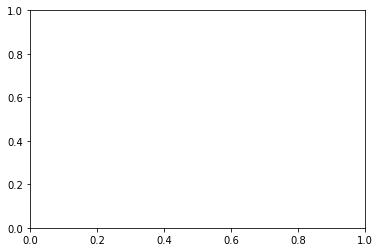

In [26]:
#学習曲線
def oresen(v_arr):
    x = np.array(range(200,480,20))
    plt.plot(x,v_arr,label="validation acc")
    plt.xlabel("Number of Data", fontsize=10) # x軸ラベル
    plt.ylabel("Accuracy", fontsize=10) # y軸ラベル
    plt.show
oresen(v_li)

In [12]:
data

,class_a,class_b,relation,type,title,source,sim_by_mcg,is_a_by_mcg,lexvec_sim,wiki2vec_sim,...,wn_sim_res,wn_sim_jcn,wn_sim_lin,has_same_word,is_include_word,bert_sim,lexvec_diff,wiki2vec_diff,bert_diff,relation_label
0,database,account_data,s2,analyse,hotel_system_2,me,3.534273,0.000000,0.405864,0.346269,...,0.596229,6.662405e-02,0.073590,0.0,0.0,0.975332,"[-0.036442, -0.018730499, -0.1123145, 0.012019...","[-0.18761757, -0.17080823, 0.24713495, -0.0983...","[0.13206336, 0.08027546, -0.01357232, 0.097821...",4
1,person,engineer,h2,sample,person_sample,uml_essence,0.512964,0.000000,0.157687,0.175974,...,2.333545,1.482017e-01,0.408868,0.0,0.0,0.950714,"[-0.033822004, 0.224855, 0.131755, 0.120946, 0...","[0.21936254, -0.4605171, -0.23989259, -0.05583...","[0.17486125, -0.12277912, 0.016683146, 0.00407...",1
2,room,hotel,s1,analyse,hotel_system_1,me,7.378811,0.000000,0.417745,0.509585,...,3.979366,1.717812e-01,0.577553,0.0,0.0,0.960316,"[0.053974997, -0.032351002, -0.045882, -0.0481...","[0.037616193, -0.10273511, 0.34396562, -0.0807...","[-0.027719725, -0.08040908, -0.08696404, -0.12...",3
3,faculty,user,h1,analyse,LibraryManagement,creately,11.385117,1.369863,0.154328,0.219077,...,0.000000,5.974787e-02,0.000000,0.0,0.0,0.928322,"[0.139304, -0.053229, 0.060622998, 0.20652899,...","[0.23291591, -0.18394254, 0.1913892, 0.2211001...","[0.062448516, 0.054628707, 0.18125094, 0.18381...",0
4,shopping_interface,shopping_basket,k,analyse,shopping_system_1,me,6.990688,0.000000,0.311641,0.375615,...,2.721860,2.500000e+299,0.263146,1.0,0.0,0.999606,"[0.032425, 0.098516494, -0.004016001, -0.02850...","[0.048278242, 0.048625052, 0.15299311, -0.0851...","[0.10029155, 0.1657108, -0.094794154, 0.032674...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,handle,bike,s1,sample,my_sample,my_samplebook,1.148567,0.000000,0.119371,0.220769,...,1.290026,6.910597e-02,0.151318,0.0,0.0,0.950408,"[-0.117424004, -0.055494003, -0.094823994, 0.0...","[0.2453539, 0.36670452, 0.3836474, 0.12040296,...","[0.09088758, 0.19013377, 0.006556943, -0.18327...",3
443,product,cart,s1,analyse,SGC,creately,1.694795,0.000000,0.219243,0.166445,...,2.305849,8.203741e-02,0.274485,0.0,0.0,0.915146,"[0.121877, 0.098452, -0.118272, -0.171242, -0....","[-0.009305939, -0.110634476, 0.39814562, 0.032...","[0.43876037, 0.09942454, 0.108824804, 0.090954...",3
444,school,teacher,s2,sample,web,web,1.364386,0.000000,0.575455,0.562681,...,0.000000,6.150305e-02,0.000000,0.0,0.0,0.984469,"[0.009508, -0.016981997, 0.0015270002, -0.0198...","[-0.03143651, 0.19860527, -0.58186024, -0.1225...","[0.02113305, 0.040494874, 0.061956123, 0.13061...",4
445,payment,order,k,analyse,monika,creately,10.558469,0.000000,0.298259,0.223843,...,0.596229,6.920586e-02,0.076234,0.0,0.0,0.971519,"[-0.040382, -0.084792, 0.007971998, -0.074694,...","[0.046864808, -0.053633504, -0.17013626, -0.03...","[4.0111203, 5.091501, -3.080672, 3.6644988, 6....",2


In [ ]:
label = ["whole","hanka1", "hanka2", "kanren", "syuyaku1", "syuyaku2"]
left=[1,2,3,4,5,6]
right=[0.68,0.81,0.83,0.61,0.67,0.53]
plt.ylabel("y axis")
plt.bar(left, height, tick_label=label, align="center")